In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.stats as st
from statsmodels.stats.multitest import multipletests

from msda import preprocessing, phospho_network as pn, \
    process_phospho_ms as ppm
from indra.databases.uniprot_client import get_gene_name

b'Skipping line 9391: expected 21 fields, saw 22\n'


## Script

In [4]:
df_timecourse = preprocessing.read_dataset('../input/Mature_Neuron_MT_pMS_Stabilizer'
                                           '1_2_time_course_ys.xlsx')

Some columns have to be renamed because the data does not conform to the expectations of the latest MSDA

In [5]:
df_timecourse = df_timecourse.rename(columns={'Max Score': 'max_score',
                                              'Protein Id': 'Uniprot_Id'})

#### Correct HGNC symbols that do not match associated Uniprot IDs
We trust the Uniprot IDs more than the HGNC symbols

In [6]:
df_timecourse['uniprot'] = df_timecourse['Uniprot_Id'].apply(lambda x:
                                                             x.split('|')[1].split('-')[0])

In [7]:
df_timecourse['hgnc'] = df_timecourse['uniprot'].apply(get_gene_name)

In [8]:
invalid_gene_symbols = df_timecourse[df_timecourse.hgnc != df_timecourse.gene_symbol]
print(len(invalid_gene_symbols.gene_symbol.unique()))

71


71 of the gene symbols in the data do not match their corresponding Uniprot IDs accounting for 139 rows in the data.

### Filter out sites with low score

The data includes a column `max_score` which measures quality of the results. We use MSDA to filter out sites with a max score below 13. **I do not recall the justification for choosing this value. This may be something to reevaluate.**

In [9]:
df_timecourse = ppm.filter_max_score(df_timecourse, max_score_cutoff=13.0)

In [10]:
df_timecourse.columns

Index(['site_id', 'siteIDstr', 'Uniprot_Id', 'gene_symbol', 'prot_description',
       'Site Position', 'Motif', 'max_score', 'low_bound', 'high_bound',
       'best_search_id', 'best_peptide_id', 'best_scan', 'best_search_name',
       'file', 'redundancy', 'sequence', 'numMatchingCompSites',
       'numQuantCompSites', 'default_spectral_counts', 'default_num_quant',
       'DIV 14 EpoB 0 (stabilizer 1)', 'DIV 14 EpoB 10 min (stabilizer 1)',
       'DIV 14 EpoB 60 min (stabilizer 1)', 'DIV 14 EpoB 2hr (stabilizer 1)',
       'DIV 14 EpoB 6hr (stabilizer 1)', 'DIV 14 Fiji 0 (stabilizer 2)',
       'DIV 14 Fiji 10 min (stabilizer 2)',
       'DIV 14 Fiji 60 min (stabilizer 2)', 'DIV 14 Fiji 2hr (stabilizer 2)',
       'DIV 14 Fiji 6hr (stabilizer 2)', 'Fold Change', 'Bar Chart', 'uniprot',
       'hgnc', 'max_score_1', 'max_score_2', 'max_score_3'],
      dtype='object')

### Fold change differences

Let's get all of the timepoint data for EpoB and calculate pairwise fold changes

In [11]:
timepoint_indices = list(range(21, 26))
timepoints = ['0min', '10min', '60min', '2hr', '6hr']

In [12]:
for i in range(5):
    for j in range(i+1, 5):
        a, b = timepoint_indices[i], timepoint_indices[j]
        df_timecourse[f'{timepoints[j]}.vs.{timepoints[i]}'] = \
        df_timecourse.iloc[:, b]/df_timecourse.iloc[:, a]
        

We calculate the maximum of the absolute value of pairwise log fold changes

In [13]:
df_timecourse['maxLogFC'] = df_timecourse.iloc[:, -10:].apply(lambda row:
                                      max([abs(np.log2(x)) for x in row]), 
                                      axis=1)

We split compound sites into separate rows and deduplicate by choosing the row with maximum
`maxLogFC`

In [14]:
df_timecourse = pn.split_sites(df_timecourse)

In [15]:
len(df_timecourse)

4095

In [14]:
df_timecourse = df_timecourse.sort_values('maxLogFC', 
                                          ascending=False).drop_duplicates(['Gene_Symbol',
                                                                            'Site'])

### Peptide mapping file

In [16]:
df_timecourse['peptide'] = df_timecourse.index

In [17]:
peptide_map = df_timecourse[['peptide', 'hgnc']]

In [18]:
peptide_map.columns = ['peptide', 'protein(s)']

In [19]:
peptide_map.to_csv('../work/EpoB_peptide_mapping.tsv', sep='\t', index=False)

### p-values

We now calcuate p-values for fold change differences. Let's examine the distribution of all pairwise foldchange differences for all peptides

In [20]:
fc_flat = df_timecourse.iloc[:, -18:-8].values.flatten()

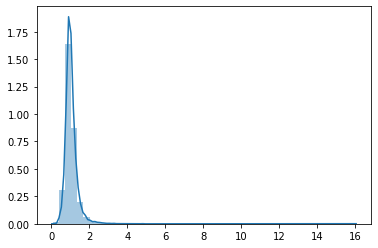

In [21]:
sns.distplot(fc_flat)

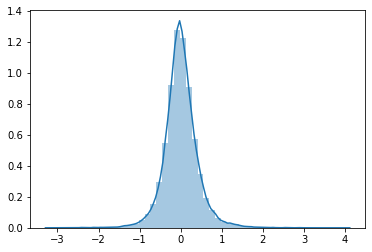

In [22]:
sns.distplot(np.log2(fc_flat))

In [23]:
st.normaltest(fc_flat)

NormaltestResult(statistic=49461.62545814729, pvalue=0.0)

In [24]:
st.normaltest(np.log2(fc_flat))

NormaltestResult(statistic=4756.291594943915, pvalue=0.0)

We will work with log2 fold changes rather than direct fold changes. Let's transform the foldchanges into log2 fold changes

In [25]:
df_timecourse.iloc[:, -18:-8] = np.log2(df_timecourse.iloc[:, -18:-8])

We then assume the log2 fold changes are independantly drawn from a normal distribution with mean 0 and standard deviation equal to the empirical standard deviation we observed above

In [26]:
print(f'The empirical standard deviation is {np.std(np.log2(fc_flat))}')

The empirical standard deviation is 0.4130868952865386


In [27]:
df_timecourse.iloc[:, -18:-8] = df_timecourse.iloc[:, -18:-8]/np.std(np.log2(fc_flat))

Let's now convert these into p-values

In [28]:
df_timecourse.iloc[:, -18:-8] = df_timecourse.iloc[:, -18:-8].applymap(lambda x:
                                                                 2*(1 - st.norm.cdf(abs(x))))

At this point we only need these p-values and the peptide so lets keep only those columns

In [40]:
p_values = df_timecourse.iloc[:,-18:-8]
p_values['peptide'] = p_values.index

Temporal Pathway Synthesizer is only interested in differences between each timepoint and the first timepoint and differences between successive timepoints, so let's only keep those in addition to the peptide column

In [41]:
p_values.columns

Index(['10min.vs.0min', '60min.vs.0min', '2hr.vs.0min', '6hr.vs.0min',
       '60min.vs.10min', '2hr.vs.10min', '6hr.vs.10min', '2hr.vs.60min',
       '6hr.vs.60min', '6hr.vs.2hr', 'peptide'],
      dtype='object')

In [42]:
p_values = p_values.iloc[:, [-1, 0, 1, 2, 3, 4, 7, 9]]

In [43]:
p_values.columns

Index(['peptide', '10min.vs.0min', '60min.vs.0min', '2hr.vs.0min',
       '6hr.vs.0min', '60min.vs.10min', '2hr.vs.60min', '6hr.vs.2hr'],
      dtype='object')

This is not the end of the story, because we are making many comparisons. We can use the Benjamini-Hochberg procedure to correct for multiple comparisons

Let's look at the flat list of all p-values

In [44]:
p_flat = p_values.iloc[:, 1:].values.flatten()

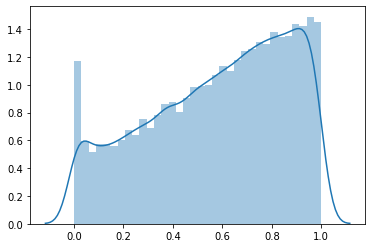

In [45]:
sns.distplot(p_flat)

This distribution suggests that there may be many p-values that are only spuriously small, but there is a peak of small p-values that are likely to correspond to significant fold changes

In [46]:
q_flat = multipletests(p_flat, method='fdr_bh')[1]

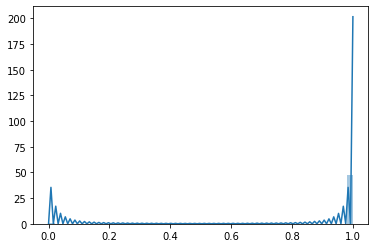

In [47]:
sns.distplot(q_flat)

The following helper function maps p_values in the original data to q_values

In [48]:
p_sorted = sorted(p_flat)
q_sorted = sorted(q_flat)

def q_map(x):
    index = np.searchsorted(p_sorted, x)
    if p_sorted[index] == x:
        return q_sorted[index]
    else:
        return (q_sorted[max(index - 1, 0)] + q_sorted[min(index + 1, len(q_sorted)-1)])/2

In [49]:
q_values = p_values.copy()
q_values.iloc[:, 1:] = q_values.iloc[:, 1:].applymap(q_map)

In the TPS paper they did not apply Benjamini-Hochberg directly to their data, but the authors used it to determine that their choice of p-value cutoff of 0.01 corresponded to controlling the False Discovery Rate (FDR) at 0.181. They claim that this is sufficient for their task and that the results are not very sensitive to the choice of cutoff. We choose the value 0.2, the above plot gives empirical support that this cutoff is reasonable.

There is a reasonable number of significant fold changes for each comparison

In [50]:
(q_values.iloc[:, 1:] < 0.2).sum()

10min.vs.0min      90
60min.vs.0min     111
2hr.vs.0min        72
6hr.vs.0min        41
60min.vs.10min    110
2hr.vs.60min        9
6hr.vs.2hr          6
dtype: int64

We can now produce the p-value files needed by TPS

In [51]:
q_values.columns

Index(['peptide', '10min.vs.0min', '60min.vs.0min', '2hr.vs.0min',
       '6hr.vs.0min', '60min.vs.10min', '2hr.vs.60min', '6hr.vs.2hr'],
      dtype='object')

In [52]:
p_first = q_values.iloc[:, [0, 1, 2, 3, 4]].copy()
p_prev = q_values.iloc[:, [0, 1, 5, 6, 7]].copy()

In [53]:
p_first.to_csv('../work/EpoB_p_values_first.tsv', sep='\t', header=False, index=False)
p_prev.to_csv('../work/EpoB_p_values_prev.tsv', sep='\t', header=False, index=False)

### Protein Prizes

In the TPS paper, protein prizes are obtained using the minimum peptide p-value over all peptides that map to a protein. They computed prizes as $-\log_{10} p$

In [54]:
p_values['min'] = p_values.iloc[:, 1:].apply(min, axis=1)

In [55]:
p_values['hgnc'] = df_timecourse['hgnc']

In [56]:
prizes = -np.log10(p_values.groupby('hgnc')['min'].min())

/Users/albertsteppi/.virtualenvs/py37/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We have one p_value of zero which corresponds to an infinite prize. Let's cap this prize at 20

In [57]:
prizes = prizes.apply(lambda x: min(x, 20))

In [58]:
prizes.sort_values(inplace=True, ascending=False)

In [59]:
prizes = pd.DataFrame(prizes).reset_index()

In [60]:
prizes.columns = ['name', 'prize']

In [61]:
prizes.to_csv('../work/EpoB_protein_prizes.tsv', sep='\t', header=True, index=False)

### Time Series File

As almost an afterthought, we need a file containing the time series data

In [57]:
time_series = df_timecourse.iloc[:, 18:23]

In [58]:
time_series.columns = ['0min', '10min', '60min', '2hr', '6hr']

In [59]:
time_series['peptide'] = time_series.index

In [60]:
time_series = time_series.iloc[:, [-1, 0, 1, 2, 3, 4]]

In [62]:
time_series.to_csv('../work/EpoB_time_series.tsv', sep='\t', index=False)